# Backtest MBRL-PETS strategy on Single Instrument Environment

In [1]:
import torch
import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import gymnasium as gym

import deeptrade.models as models
import deeptrade.planning as planning
import deeptrade.util
import deeptrade.util.common as common_utils
import deeptrade.util.replay_buffer as replay_buffer

import deeptrade.env
import deeptrade.env.termination_fns as term_fns
import deeptrade.env.reward_fns as reward_fns

import deeptrade.env.cartpole_continuous as cartpole_env

In [2]:
seed = 0
ensemble_size = 5
num_trials = 10
trial_length = 200
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Setup Environment
env = gym.make("SingleInstrument-v0", seed=seed, price_gen_info={"mean": 1.0, "std": 0.0, "n_days": 50})
# env = cartpole_env.CartPoleEnv(render_mode="rgb_array")
env.reset(seed=seed)
rng = np.random.default_rng(seed=seed)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
reward_fn = reward_fns.single_instrument
term_fn = term_fns.margin_call

# reward_fn = reward_fns.cartpole
# term_fn = term_fns.cartpole

# in_size = obs_shape[0] + act_shape[0]
# out_size = obs_shape[0]

cfg_dict = {
    "dynamics_model": {
        "_target_": "deeptrade.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05
    }
}

cfg = OmegaConf.create(cfg_dict)

/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [3]:
dynamics_model = common_utils.create_one_dim_tr_model(cfg, obs_shape, act_shape)
model_env = models.ModelEnv(env, dynamics_model, term_fn, reward_fn, generator=generator)

In [4]:
replay_buffer = common_utils.create_replay_buffer(cfg, obs_shape, act_shape)

In [5]:
common_utils.rollout_agent_trajectories(
    env=env,
    steps_or_trials_to_collect=trial_length,
    agent=planning.RandomAgent(env),
    agent_kwargs={},
    replay_buffer=replay_buffer,
    trial_length=trial_length,
)

/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


[np.float64(493.78224189579487),
 np.float64(-254.24897229671478),
 np.float64(-592.637009948492),
 np.float64(-254.3088954091072),
 np.float64(115.1574183255434),
 np.float64(235.94232535362244)]

In [6]:
agent_cfg = OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "deeptrade.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 15,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "deeptrade.planning.CEMOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 500,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "clipped_normal": False
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

In [7]:
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)
dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats
all_rewards = []

for trial in range(num_trials):
    obs, _ = env.reset()
    agent.reset()
    
    terminated = False
    total_reward = 0.0
    steps_trial = 0
    while not terminated:
        if steps_trial == 0:
            dynamics_model.update_normalizer(replay_buffer.get_all()) # update normalizer stats 
            
            dataset_train, dataset_val = common_utils.get_basic_buffer_iterators(
                replay_buffer,
                batch_size=cfg.overrides.model_batch_size,
                val_ratio=cfg.overrides.validation_ratio,
                ensemble_size=ensemble_size,
                shuffle_each_epoch=True,
                bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
            )
            
            model_trainer.train(
                dataset_train, 
                dataset_val=dataset_val, 
                num_epochs=50, 
                patience=50,
                silent=True
            )
        print(obs.shape, env.unwrapped.time)
        next_obs, reward, terminated, truncated, _ = common_utils.step_env_and_add_to_buffer(
            env=env,
            obs=obs,
            agent=agent,
            agent_kwargs={},
            replay_buffer=replay_buffer
        )
        obs = next_obs
        total_reward += reward
        steps_trial += 1
        
        if steps_trial == trial_length or truncated:
            break
    
    all_rewards.append(total_reward)        

    

(12,) 11
(12,) 12
(12,) 13
(12,) 14
(12,) 15
(12,) 16
(12,) 17
(12,) 18
(12,) 19
(12,) 20
(12,) 21
(12,) 22
(12,) 23
(12,) 24
(12,) 25
(12,) 26
(12,) 27
(12,) 28
(12,) 29
(12,) 30
(12,) 31
(12,) 32
(12,) 33
(12,) 34
(12,) 35
(12,) 36
(12,) 37
(12,) 38
(12,) 39
(12,) 40
(12,) 41
(12,) 42
(12,) 43
(12,) 44
(12,) 45
(12,) 46
(12,) 47
(12,) 11
(12,) 12
(12,) 13
(12,) 14
(12,) 15
(12,) 16
(12,) 17
(12,) 18
(12,) 19
(12,) 20
(12,) 21
(12,) 22
(12,) 23
(12,) 24
(12,) 25
(12,) 26
(12,) 27
(12,) 28
(12,) 29
(12,) 30
(12,) 31
(12,) 32
(12,) 33
(12,) 34
(12,) 35
(12,) 36
(12,) 37
(12,) 38
(12,) 39
(12,) 40
(12,) 41
(12,) 42
(12,) 43
(12,) 44
(12,) 45
(12,) 46
(12,) 47
(12,) 11
(12,) 12
(12,) 13
(12,) 14
(12,) 15
(12,) 16
(12,) 17
(12,) 18
(12,) 19
(12,) 20
(12,) 21
(12,) 22
(12,) 23
(12,) 24
(12,) 25
(12,) 26
(12,) 27
(12,) 28
(12,) 29
(12,) 30
(12,) 31
(12,) 32
(12,) 33
(12,) 34
(12,) 35
(12,) 36
(12,) 37
(12,) 38
(12,) 39
(12,) 40
(12,) 41
(12,) 42
(12,) 43
(12,) 44
(12,) 45
(12,) 46
(12,) 47
(

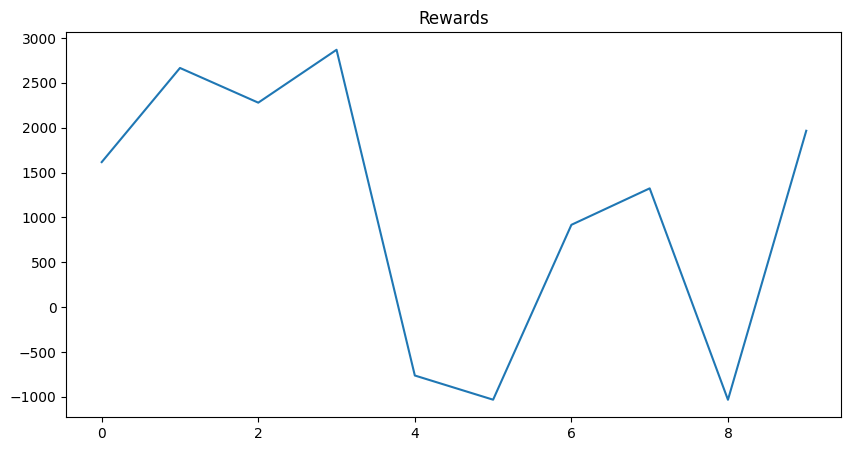

In [8]:
all_rewards
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(all_rewards)
ax.set_title("Rewards")
fig.show()